In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# 1. Data cleaning

In [3]:
original = pd.read_csv("../data/BankChurners.csv")
balance_df = pd.read_csv("../data/botswana_bank_customer_churn.csv")
technical_df = pd.read_csv("../data/User churn.csv")

In [4]:
# removing irrelevent columns
original = original.drop(original.columns[[-1, -2]], axis=1)
original = original.drop(columns=['Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Contacts_Count_12_mon','Total_Ct_Chng_Q4_Q1'])

# renaming the datasets
original = original.rename(columns={'Months_on_book' : 'Month_with_bank',
                                    'Total_Relationship_Count' : 'No_of_product',
                                    'Total_Trans_Ct' : 'Total_Trans_Count'})

# removing Na from the dataset
original_Unknown = original[original.isin(['Unknown']).any(axis=1)] # someone handle the unknown please
original = original[~original.isin(['Unknown']).any(axis=1)]


In [5]:
# this function will remove the k,$ and + sign in the income category column
def clean_col(x):
        if 'K' in x:
            return x.replace('K','').replace('$','')
        elif '+' in x:
            return x.replace('+','')
        elif x =='Less than 40':
            return x.split()[2]
        return x
    
original['Income_Category']=original['Income_Category'].apply(clean_col)

In [6]:
# Converting object into category
categorical_features = ['Attrition_Flag','Gender','Education_Level','Marital_Status','Income_Category','Card_Category']
for category in categorical_features:
    original[category] = original[category].astype('category')

# 2. Synthetic data 

## 2.1 Balance dataset

Adding in  `Credit Score`,`Outstanding Loans`, `Balance` from balance dataset. The final dataframe is stored as `final_df`

### 2.1.1 Feature selection

In [7]:
# subsetting from the original data
required_features = ["CLIENTNUM","Customer_Age","Gender","Income_Category","No_of_product"]
subset_original = original.loc[:,required_features]

# subsetting from the income data
required_features2 = ['Date of Birth','Gender','Income','NumOfProducts','Credit Score','Outstanding Loans', 'Balance']
subset_balance = balance_df.loc[:,required_features2]

### 2.1.2 Data Cleaning

In [8]:
# Changing date of birth to date time and them convert it to age
subset_balance['Date of Birth'] = pd.to_datetime(subset_balance['Date of Birth'])
reference_date = pd.Timestamp('2024-01-01')
subset_balance['Date of Birth'] = reference_date.year - subset_balance['Date of Birth'].dt.year

# Changing income into income category
bins = [0, 40000, 60000, 80000, 120000, float('inf')]
labels = ['Less than 40', '40 - 60', '60 - 80', '80 - 120', '120 +']
subset_balance['Income'] = pd.cut(subset_balance['Income'], bins=bins, labels=labels, right=False)

# Recoding Male to M...
subset_balance['Gender'] = subset_balance['Gender'].replace({'Male':'M','Female':'F'})

# Renaming the balance_subset dataframe
subset_balance = subset_balance.rename(columns = {'Date of Birth' : "Customer_Age", 
                                        'Income' : "Income_Category", 'NumOfProducts' : "No_of_product"})

# Converting object to category
subset_balance['Gender'] = subset_balance['Gender'].astype('category')

### 2.1.3 Data Transformation

In [9]:
#Scaling 
scaler = MinMaxScaler()
subset_balance[['Customer_Age','No_of_product']] = scaler.fit_transform(subset_balance[['Customer_Age','No_of_product']])
subset_original[['Customer_Age','No_of_product']] = scaler.fit_transform(subset_original[['Customer_Age','No_of_product']])

# Encode the categorical variables
le_gender = LabelEncoder()
subset_balance['Gender_Encoded'] = le_gender.fit_transform(subset_balance['Gender'])
subset_original['Gender_Encoded'] = le_gender.fit_transform(subset_original['Gender'])

le_income = LabelEncoder()
subset_balance['Income_Category_Encoded'] = le_income.fit_transform(subset_balance['Income_Category'])
subset_original['Income_Category_Encoded'] = le_income.fit_transform(subset_original['Income_Category'])

# Extract relevant features for clustering
features_balance = subset_balance[['Customer_Age', 'No_of_product', 'Gender_Encoded', 'Income_Category_Encoded']]
features_original = subset_original[['Customer_Age', 'No_of_product', 'Gender_Encoded', 'Income_Category_Encoded']]

### 2.1.4 Model Training

In [10]:
# Perform KMeans clustering on balance data and find optimal clusters
cluster_range = range(2, 7)  # Define the range of cluster numbers to test
inertia_values = []  # Inertia will help determine the optimal cluster number

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_balance)
    inertia_values.append(kmeans.inertia_)

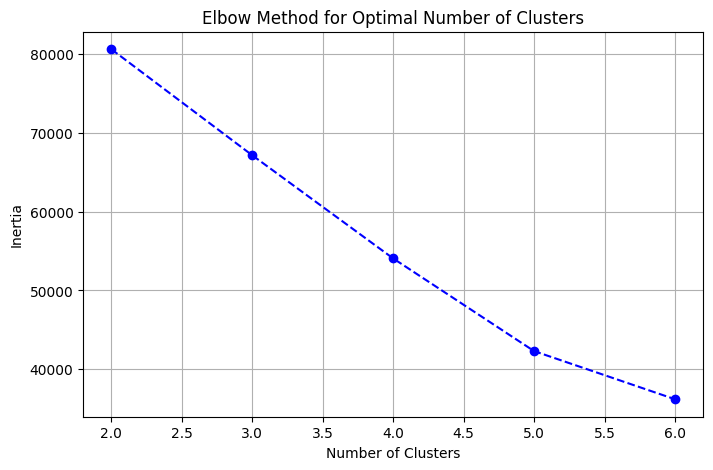

In [11]:
# Plot the elbow method to determine the best cluster count
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [12]:
# Fit the final KMeans model with the selected number of clusters
optimal_k = 5  # Choosen based on the elbow plot
kmeans_final = KMeans(n_clusters=optimal_k, random_state=3101)
kmeans_final.fit(features_balance)
subset_balance['Cluster_Labels'] = kmeans_final.labels_

#Predict cluster labels for the original subset using the same KMeans model
subset_original['Cluster_Labels'] = kmeans_final.predict(features_original)

In [13]:
# List of target variables
target_columns = ['Credit Score','Outstanding Loans', 'Balance']

# Dictionary to hold fitted parameters (mean, std) for each cluster and each target variable
cluster_params = {}

for target in target_columns:
    cluster_params[target] = {}
    # Group by clusters
    for cluster in subset_balance['Cluster_Labels'].unique():
        cluster_data = subset_balance[subset_balance['Cluster_Labels'] == cluster][target]
        # Fit a normal distribution to the data in the cluster
        mean, std = norm.fit(cluster_data)
        cluster_params[target][cluster] = (mean, std)

In [14]:
# Create a function to draw samples based on the cluster label using CLIENTNUM
def generate_synthetic_data_with_clientnum(base_data, cluster_params, target):
    # Initialize a dictionary for storing CLIENTNUM and synthetic values
    synthetic_values = {}
    
    # Iterate over each record in the base data
    for idx, row in base_data.iterrows():
        clientnum = row['CLIENTNUM']  # Fetch the unique identifier
        cluster_label = row['Cluster_Labels']  # Assuming cluster labels are already assigned to base data
        mean, std = cluster_params[target][cluster_label]
        
        # Draw a sample from the normal distribution
        synthetic_value = norm.rvs(loc=mean, scale=std)
        
        # Store the synthetic value with CLIENTNUM as the key
        synthetic_values[clientnum] = synthetic_value
    
    return synthetic_values

# Generate synthetic data for each target variable in the original subset
for target in target_columns:
    synthetic_data = generate_synthetic_data_with_clientnum(subset_original, cluster_params, target)
    
    # Add the synthetic data to the original subset using CLIENTNUM as the identifier
    subset_original[f'{target}'] = subset_original['CLIENTNUM'].map(synthetic_data)

## 2.2 Technical dataset

This section aims to generate artificial data for digital engagement.

### 2.2.1 Feature Selection

In [15]:
required_features_original = ['CLIENTNUM', 'Gender', 'Customer_Age', 'Marital_Status', 'Dependent_count', 'Attrition_Flag']
subset_original2 = original.loc[:,required_features_original]

required_features_tech = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Churn',
                          'PhoneService', 'InternetService', 'TechSupport', 'PaperlessBilling', 'PaymentMethod']
subset_technical = technical_df.loc[:,required_features_tech]

### 2.2.2 Data Cleaning

In [16]:
subset_original2['SeniorCitizen'] = (subset_original2['Customer_Age'] > 60).astype(int)
subset_original2['Dependents'] = subset_original2['Dependent_count'].apply(lambda x: 'Yes' if x > 0 else 'No')

subset_original2.drop(['Customer_Age', 'Dependent_count'], axis = 1, inplace = True)

subset_technical['gender'] = subset_technical['gender'].replace({'Male':'M','Female':'F'})
subset_technical['Churn'] = subset_technical['Churn'].replace({'Attrited Customer':'Yes','Existing Customer':'No'})
subset_technical['Partner'] = subset_technical['Partner'].replace({'Married':'Yes','Single':'No'})

subset_technical = subset_technical.rename(columns = {'gender' : "Gender", 'Churn' : "Attrition_Flag", 'Partner' : "Marital_Status"})

### 2.2.3 Data Transformation

In [17]:
from sklearn.preprocessing import LabelEncoder

# List of categorical features
modified_features_tech = ['Gender', 'SeniorCitizen', 'Marital_Status', 'Dependents', 'Attrition_Flag', 
                          'PhoneService', 'InternetService', 'TechSupport', 'PaperlessBilling', 'PaymentMethod']

# Initialize dictionaries to store encodings
encodings_technical = {}
encodings_original2 = {}

# Encoding for subset_technical
for feature in modified_features_tech:
    # Convert to category type
    subset_technical[feature] = subset_technical[feature].astype('category')
    if feature in subset_original2:
        subset_original2[feature] = subset_original2[feature].astype('category')

# Apply LabelEncoder and show mappings
for feature in modified_features_tech:
    le_technical = LabelEncoder()
    
    # Fit and transform for subset_technical
    subset_technical[feature + '_Encoded'] = le_technical.fit_transform(subset_technical[feature])
    
    # Store the mapping for subset_technical
    encodings_technical[feature] = dict(zip(le_technical.classes_, le_technical.transform(le_technical.classes_)))
    
    # If feature exists in subset_original2, apply encoding
    if feature in subset_original2:
        le_original2 = LabelEncoder()
        subset_original2[feature + '_Encoded'] = le_original2.fit_transform(subset_original2[feature])
        
        # Store the mapping for subset_original2
        encodings_original2[feature] = dict(zip(le_original2.classes_, le_original2.transform(le_original2.classes_)))

features_original2 = subset_original2[['Gender_Encoded', 'SeniorCitizen_Encoded', 'Marital_Status_Encoded', 'Dependents_Encoded', 'Attrition_Flag_Encoded']]
features_technical = subset_technical[['Gender_Encoded', 'SeniorCitizen_Encoded', 'Marital_Status_Encoded', 'Dependents_Encoded', 'Attrition_Flag_Encoded']]
# Display the encoding mappings
print("Encodings for subset_technical:")
for feature, mapping in encodings_technical.items():
    print(f"{feature}: {mapping}")

print("\nEncodings for subset_original2:")
for feature, mapping in encodings_original2.items():
    print(f"{feature}: {mapping}")

Encodings for subset_technical:
Gender: {'F': np.int64(0), 'M': np.int64(1)}
SeniorCitizen: {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
Marital_Status: {'No': np.int64(0), 'Yes': np.int64(1)}
Dependents: {'No': np.int64(0), 'Yes': np.int64(1)}
Attrition_Flag: {'No': np.int64(0), 'Yes': np.int64(1)}
PhoneService: {'No': np.int64(0), 'Yes': np.int64(1)}
InternetService: {'DSL': np.int64(0), 'Fiber optic': np.int64(1), 'No': np.int64(2)}
TechSupport: {'No': np.int64(0), 'No internet service': np.int64(1), 'Yes': np.int64(2)}
PaperlessBilling: {'No': np.int64(0), 'Yes': np.int64(1)}
PaymentMethod: {'Bank transfer (automatic)': np.int64(0), 'Credit card (automatic)': np.int64(1), 'Electronic check': np.int64(2), 'Mailed check': np.int64(3)}

Encodings for subset_original2:
Gender: {'F': np.int64(0), 'M': np.int64(1)}
SeniorCitizen: {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
Marital_Status: {'Divorced': np.int64(0), 'Married': np.int64(1), 'Single': np.int64(2)}
Dependents

### 2.2.4 Model Training

In [18]:
# Perform KMeans clustering on balance data and find optimal clusters
cluster_range2 = range(2, 10)  # Define the range of cluster numbers to test
inertia_values2 = []  # Inertia will help determine the optimal cluster number

for k in cluster_range2:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_technical)
    inertia_values2.append(kmeans.inertia_)

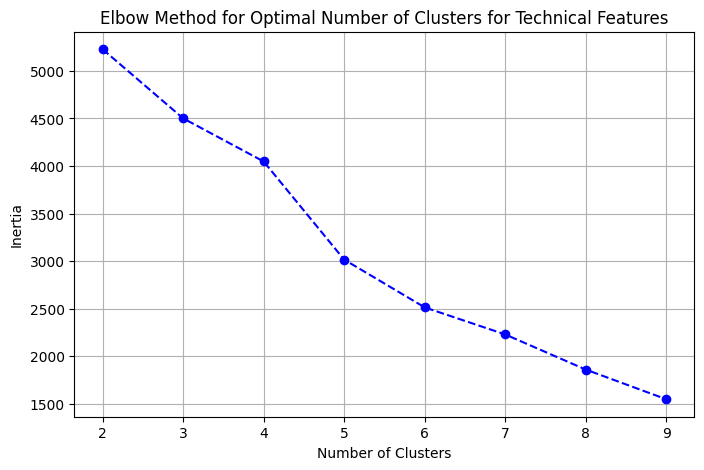

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(cluster_range2, inertia_values2, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal Number of Clusters for Technical Features')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [20]:
# Fit the final KMeans model with the selected number of clusters
optimal_k_technical = 5  # Choosen based on the elbow plot
kmeans_technical = KMeans(n_clusters=optimal_k, random_state=3101)
kmeans_technical.fit(features_technical)
subset_technical['Cluster_Labels'] = kmeans_technical.labels_

#Predict cluster labels for the original subset using the same KMeans model
subset_original2['Cluster_Labels'] = kmeans_technical.predict(features_original2)

In [21]:
# Calculate the distribution of PhoneService
phone_service_distribution = (
    subset_technical.groupby('Cluster_Labels')['PhoneService_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of InternetService
internet_service_distribution = (
    subset_technical.groupby('Cluster_Labels')['InternetService_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of TechSupport
tech_support_distribution = (
    subset_technical.groupby('Cluster_Labels')['TechSupport_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of PaperlessBilling
paperless_billing_distribution = (
    subset_technical.groupby('Cluster_Labels')['PaperlessBilling_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of PaymentMethod
payment_method_distribution = (
    subset_technical.groupby('Cluster_Labels')['PaymentMethod_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

In [22]:
def generate_synthetic_features(df, distribution):
    synthetic_feature = []
    
    for _, row in df.iterrows():
        cluster = row['Cluster_Labels']
        
        # Sample a new feature based on the defined probabilities
        sample = np.random.choice(
            distribution.columns,  # Possible features to sample from
            p=distribution.loc[cluster].values  # Probabilities for the respective features
        )
        synthetic_feature.append(sample)
            
    return synthetic_feature

# Generate synthetic features
subset_original2['PhoneService'] = generate_synthetic_features(subset_original2, phone_service_distribution)
subset_original2['InternetService'] = generate_synthetic_features(subset_original2, internet_service_distribution)
subset_original2['TechSupport'] = generate_synthetic_features(subset_original2, tech_support_distribution)
subset_original2['PaperlessBilling'] = generate_synthetic_features(subset_original2, paperless_billing_distribution)
subset_original2['PaymentMethod'] = generate_synthetic_features(subset_original2, payment_method_distribution)

##### Final synthetic dataframe

In [23]:
# Making the final segmentation data for actual segmentation

# Feature from original dataset
feature_from_original = ['CLIENTNUM','Income_Category','No_of_product',
                         'Total_Trans_Amt', 'Total_Trans_Count']
temp1 = original.loc[:,feature_from_original]

# Feature from balance
final_balance_features = ['CLIENTNUM','Credit Score',
       'Outstanding Loans', 'Balance']
temp2 = subset_original.loc[:,final_balance_features]

# Feature from technical
final_tech_features = ['CLIENTNUM','PhoneService','InternetService','TechSupport','PaperlessBilling','PaymentMethod']
temp3  = subset_original2.loc[:,final_tech_features]


# Joingning them all together
temp4 = pd.merge(temp1, temp2, on='CLIENTNUM', how='inner')
final_df = pd.merge(temp4, temp3, on='CLIENTNUM', how = 'inner')

# 3. Customer Segmentation

## 3.1 Feature Engineering Rules

### 3.1.1 Digital Capability
We will combine the following features to create the `Digital_Capability` score:
- **PhoneService**: 
  - If the customer has phone service (`PhoneService = 1`), add 1 point. 
  - Else, do not award any point.
- **InternetService**: 
  - If the customer has **Fiber optic internet**(`InternetService = 1`) or **DSL** (`InternetService = 0`), add 1 points.
  - If **NO** (`InternetService = 2`), do not award any point.
- **TechSupport**: 
  - If the customer uses tech support (`TechSupport = 2`), add 1 points.
  - If no tech support (`TechSupport = 0` or `TechSupport = 1`), add 0 points.
- **PaperlessBilling**: 
  - If the customer has paperless billing (`PaperlessBilling = 1`), add 1 point
  - Else, do not add any point.
- **PaymentMethod**: 
  - If the customer uses **automatic payments** (`PaymentMethod = 0 or 1`), add 2 points.
  - If **electronic check** (`PaymentMethod = 2`), add 1 point.
  - If **mailed check** (`PaymentMethod = 3`), do not add any point.

**Total score range**: 0 to 6  
- **Digital Capability**: If digital capability score > 2, return True (indicating digitally capable). Otherwise, return False.

---

### 3.1.3 Financial Status

We will combine the following features to create the `Financial_Status` score using **percentiles**, except for **Income_Category**, which will use strict rules:

- **Income_Category** (strict rule):
  - Assign points based on income category:
    - If the income is `120+`, add **3 points**.
    - If the income is between `80 - 120`, add **2 points**.
    - If the income is between `60 - 80`, add **1 point**.
    - If income is `Less than 40`, add **0 points**.

- **Credit Score**:
  - Assign points based on the credit score percentile:
    - If the credit score is in the top 20th percentile, add **3 points**.
    - If the credit score is between the 20th and 50th percentile, add **2 points**.
    - If the credit score is between the 50th and 80th percentile, add **1 point**.
    - If below the 80th percentile, add **0 points**.

- **Outstanding Loans**:
  - Assign points based on the loan amount percentile:
    - If the loan amount is in the bottom 20th percentile (e.g., less than $10,000), add **3 points**.
    - If the loan amount is between the 20th and 50th percentile, add **2 points**.
    - If the loan amount is between the 50th and 80th percentile, add **1 point**.
    - If above the 80th percentile, add **0 points**.

- **Balance**:
  - Assign points based on the balance percentile:
    - If the balance is in the top 20th percentile, add **3 points**.
    - If the balance is between the 20th and 50th percentile, add **2 points**.
    - If the balance is between the 50th and 80th percentile, add **1 point**.
    - If below the 80th percentile, add **0 points**.

**Total score range**: 0 to 12 (higher means stronger financial status).

---

### 3.1.3 Transaction Behavior
We will create a composite score for `Transaction_Behavior`:
- **Total_Trans_Amt**: 
  - If the total transaction amount is in the top 20%, add **3 points**.
  - If the total transaction amount is in the 20th and 50th percentile, add **2 points**.
  - If the total transaction amount is in the 50th and 80th percentile, add **1 point**.
- **Total_Trans_Count**: 
  - If the total transaction count is in the top 20%, add **3 points**.
  - If the total transaction count is in the 20th and 50th percentile, add **2 points**.
  - If the total transaction count is in the 50th and 80th percentile, add **1 point**.

**Total score range**: 0 to 6 (higher means frequent and high-value transactions).

---

### 3.1.4 Product Usage
We will categorize customers based on the number of products they use and assign them a `Product_Usage` label:
- **Heavy User**: Customers using more than 4 products, **award 3 points**
- **Moderate User**: Customers using 3-4 products, **award 2 points**
- **Light User**: Customers using 1-2 or fewer products, **award 1 point**

---

### 3.1.5 Loyalty Score
The `Loyalty` score will be a combination of the **Transaction Behavior** and **Product Usage** scores.

**Total Loyalty score range**: 0 to 9

### Feature Integration: Banking Behavior and Customer Preferences

#### 1. **Loyalty**
Combines `Transaction_Behavious` and `Product_Usage` to measure how engaged the customer is with the bank.
Value ranges from 0-9
#### 2. **Financial Status**
Measures the customer’s financial health based on `income`, `credit score`, `outstanding loans`, and `balance`.
Value ranges from 0-12
#### 3. **Digital capability**
Captures if the customer is good at techonologies.
  Score based on `PhoneService`, `InternetService`, `TechSupport`, `PaperlessBilling`, and `PaymentMethod`.

### Rule-Based Segmentation Based on Banking Behavior and Customer Preferences

#### Classification Ranges Based on Percentiles:

##### 1. **Loyalty**:
We will categorize customers into **Low**, **Moderate**, and **High** loyalty based on the composite `Loyalty_Score`:
- **Low (L)**: Loyalty score in the **bottom 20%** of the population.
- **Moderate (M)**: Loyalty score between the **20th and 80th percentile**.
- **High (H)**: Loyalty score in the **top 20%** of the population.

##### 2. **Financial Status**:
We will categorize customers into **Low**, **Moderate**, and **High** financial status based on the `Financial_Status` score:
- **Low (L)**: Financial status score in the **bottom 20%** of the population.
- **Moderate (M)**: Financial status score between the **20th and 80th percentile**.
- **High (H)**: Financial status score in the **top 20%** of the population.

#### Segments:

1. **Low Financial status, Low Loyalty**:
   - **Financial status**: Low 
   - **Loyalty**: Low 
   - **Business Insight**: Customers in this segment likely include students or younger individuals just starting out, or elderly customers who aren't financially active. A focus on retention strategies and promoting entry-level products (like low-cost savings accounts) is key. Physical outreach methods may be necessary, especially if they lack digital capability.

2. **High Financial status, High Loyalty**:
   - **Financial status**: High 
   - **Loyalty**: High 
   - **Business Insight**: These are premium customers, likely professionals or established individuals with a strong engagement in banking products. Offering personalized premium services, loyalty rewards, and investment products should be prioritized. Reach out via digital channels for convenience, or through dedicated relationship managers.

3. **High Financial status, Low or Moderate Loyalty**:
   - **Financial status**: High
   - **Loyalty**: Low or Moderate
   - **Business Insight**: These financially capable customers may not be fully engaged with the bank’s products. They could be busy professionals or high-income earners who focus on other banks. Increase engagement by promoting exclusive offers, premium credit cards, or mortgage products. Encourage digital engagement to make banking easier and more convenient for them.

4. **Low or Moderate Financial status, High Loyalty**:
   - **Financial status**: Low or Moderate
   - **Loyalty**: High
   - **Business Insight**: These customers, while financially modest, are loyal users of the bank’s products. Likely individuals in middle-income brackets or those rebuilding credit, they should be offered value-driven products such as cashback credit cards or debt consolidation services. Educating them on budgeting tools via digital channels may improve their financial health.

5. **Moderate Financial status, Moderate Loyalty** + **Low Financial status, Moderate Loyalty**, **Moderate Financial status, Low Loyalty**:
   - **Financial status**: Moderate or Low
   - **Loyalty**: Moderate or Low
   - **Business Insight**: This segment represents customers with no strong financial activity or engagement. They could be occasional users, young professionals, or middle-income families. Focus on financial education, product bundling, or targeted campaigns that address their potential needs, such as home loans or long-term savings plans. If digitally capable, promote app-based interactions; otherwise, rely on physical channels.
  
---

**Digital Capability**:
- Customers who are digitally capable should be prioritized for online banking services, mobile app usage, and digital communication.
- Non-digitally capable customers may prefer physical channels, like branch visits or mailed offers, so consider traditional methods of outreach.

In [24]:
class CustomerSegmentation:
    def __init__(self, df):
        self.df = df.copy()
        self.percentiles = {}

    def calculate_initial_percentiles(self):
        # Calculate percentiles for features before Loyalty and Financial_Status are created
        self.percentiles['Credit_Score'] = self.df['Credit Score'].quantile([0.2, 0.5, 0.8])
        self.percentiles['Outstanding_Loans'] = self.df['Outstanding Loans'].quantile([0.2, 0.5, 0.8])
        self.percentiles['Balance'] = self.df['Balance'].quantile([0.2, 0.5, 0.8])
        self.percentiles['Total_Trans_Amt'] = self.df['Total_Trans_Amt'].quantile([0.2, 0.5, 0.8])
        self.percentiles['Total_Trans_Count'] = self.df['Total_Trans_Count'].quantile([0.2, 0.5, 0.8])

    def calculate_final_percentiles(self):
        # After Loyalty and Financial_Status have been created, calculate their percentiles
        self.percentiles['Loyalty'] = self.df['Loyalty'].quantile([0.2, 0.8])
        self.percentiles['Financial_Status'] = self.df['Financial_Status'].quantile([0.2, 0.8])

    def digital_capability(self, row):
        score = 0
        score += row['PhoneService']
        score += 1 if row['InternetService'] in [0, 1] else 0
        score += 1 if row['TechSupport'] == 2 else 0
        score += row['PaperlessBilling']
        score += 2 if row['PaymentMethod'] in [0, 1] else 1 if row['PaymentMethod'] == 2 else 0
        return score > 2

    def financial_status(self, row):
        score = 0
        # Income Category (strict rules)
        if row['Income_Category'] == '120 +':
            score += 3
        elif row['Income_Category'] == '80 - 120':
            score += 2
        elif row['Income_Category'] == '60 - 80':
            score += 1

        # Credit Score (percentile-based)
        if row['Credit Score'] > self.percentiles['Credit_Score'][0.8]:
            score += 3
        elif row['Credit Score'] > self.percentiles['Credit_Score'][0.5]:
            score += 2
        elif row['Credit Score'] > self.percentiles['Credit_Score'][0.2]:
            score += 1

        # Outstanding Loans (percentile-based)
        if row['Outstanding Loans'] < self.percentiles['Outstanding_Loans'][0.2]:
            score += 3
        elif row['Outstanding Loans'] < self.percentiles['Outstanding_Loans'][0.5]:
            score += 2
        elif row['Outstanding Loans'] < self.percentiles['Outstanding_Loans'][0.8]:
            score += 1

        # Balance (percentile-based)
        if row['Balance'] > self.percentiles['Balance'][0.8]:
            score += 3
        elif row['Balance'] > self.percentiles['Balance'][0.5]:
            score += 2
        elif row['Balance'] > self.percentiles['Balance'][0.2]:
            score += 1

        return score

    def transaction_behavior(self, row):
        score = 0
        if row['Total_Trans_Amt'] > self.percentiles['Total_Trans_Amt'][0.8]:
            score += 3
        elif row['Total_Trans_Amt'] > self.percentiles['Total_Trans_Amt'][0.5]:
            score += 2
        elif row['Total_Trans_Amt'] > self.percentiles['Total_Trans_Amt'][0.2]:
            score += 1

        if row['Total_Trans_Count'] > self.percentiles['Total_Trans_Count'][0.8]:
            score += 3
        elif row['Total_Trans_Count'] > self.percentiles['Total_Trans_Count'][0.5]:
            score += 2
        elif row['Total_Trans_Count'] > self.percentiles['Total_Trans_Count'][0.2]:
            score += 1

        return score

    def product_usage(self, row):
        if row['No_of_product'] > 4:
            return 3
        elif 3 <= row['No_of_product'] <= 4:
            return 2
        return 1

    def loyalty_score(self, row):
        return self.transaction_behavior(row) + self.product_usage(row)

    def assign_loyalty_level(self, loyalty_score):
        if loyalty_score > self.percentiles['Loyalty'][0.8]:
            return 'High'
        elif loyalty_score > self.percentiles['Loyalty'][0.2]:
            return 'Moderate'
        else:
            return 'Low'

    def assign_financial_status_level(self, financial_status_score):
        if financial_status_score > self.percentiles['Financial_Status'][0.8]:
            return 'High'
        elif financial_status_score > self.percentiles['Financial_Status'][0.2]:
            return 'Moderate'
        else:
            return 'Low'

    def assign_segment(self, row):
        # Assign loyalty and financial status levels
        loyalty_label = self.assign_loyalty_level(row['Loyalty'])
        financial_status_label = self.assign_financial_status_level(row['Financial_Status'])

        # Return segment based on the classification of loyalty and financial status
        if financial_status_label == 'Low' and loyalty_label == 'Low':
            return 'Low Financial status, Low Loyalty'
        elif financial_status_label == 'High' and loyalty_label == 'High':
            return 'High Financial status, High Loyalty'
        elif financial_status_label == 'High' and loyalty_label in ['Moderate', 'Low']:
            return 'High Financial status, Low or Moderate Loyalty'
        elif financial_status_label in ['Moderate', 'Low'] and loyalty_label == 'High':
            return 'Low or Moderate Financial status, High Loyalty'
        else:
            return 'Moderate or Low Financial status, Moderate or Low Loyalty'

    def perform_segmentation(self):
        # Calculate percentiles for features before Loyalty and Financial Status
        self.calculate_initial_percentiles()

        self.df['Digital_Capability'] = self.df.apply(self.digital_capability, axis=1)
        self.df['Financial_Status'] = self.df.apply(self.financial_status, axis=1)
        self.df['Loyalty'] = self.df.apply(self.loyalty_score, axis=1)

        # After Loyalty and Financial_Status are created, calculate their percentiles
        self.calculate_final_percentiles()

        # Assign segment based on loyalty and financial status
        self.df['Segment'] = self.df.apply(self.assign_segment, axis=1)

        return self.df[['Segment', 'Digital_Capability']]

    def predict(self, new_data):
        # Apply segmentation logic to new data
        new_data['Digital_Capability'] = new_data.apply(self.digital_capability, axis=1)
        new_data['Financial_Status'] = new_data.apply(self.financial_status, axis=1)
        new_data['Loyalty'] = new_data.apply(self.loyalty_score, axis=1)

        # Calculate percentiles for Loyalty and Financial Status based on new data
        self.calculate_final_percentiles()

        new_data['Segment'] = new_data.apply(self.assign_segment, axis=1)
        return new_data[['Segment', 'Digital_Capability']]

In [25]:
# Initialize and test with final_df
segmentation_test = CustomerSegmentation(final_df)
segmentation_result = segmentation_test.perform_segmentation()

# Output first few rows and value counts for segmentation
print(segmentation_result.head())
print(segmentation_result['Segment'].value_counts())

                                             Segment  Digital_Capability
0  Moderate or Low Financial status, Moderate or ...                True
1  Moderate or Low Financial status, Moderate or ...                True
2     High Financial status, Low or Moderate Loyalty                True
3                  Low Financial status, Low Loyalty                True
4                  Low Financial status, Low Loyalty                True
Segment
Moderate or Low Financial status, Moderate or Low Loyalty    5321
High Financial status, Low or Moderate Loyalty                879
Low or Moderate Financial status, High Loyalty                509
Low Financial status, Low Loyalty                             292
High Financial status, High Loyalty                            80
Name: count, dtype: int64


# 4. Visualisation

Customer characteristics involved: **product usage**, **transaction history**, **digital engagement**.

## 4.1 Visualisation for Product Usage

### 4.1.1 Bar Plot for Product Usage across All Segments

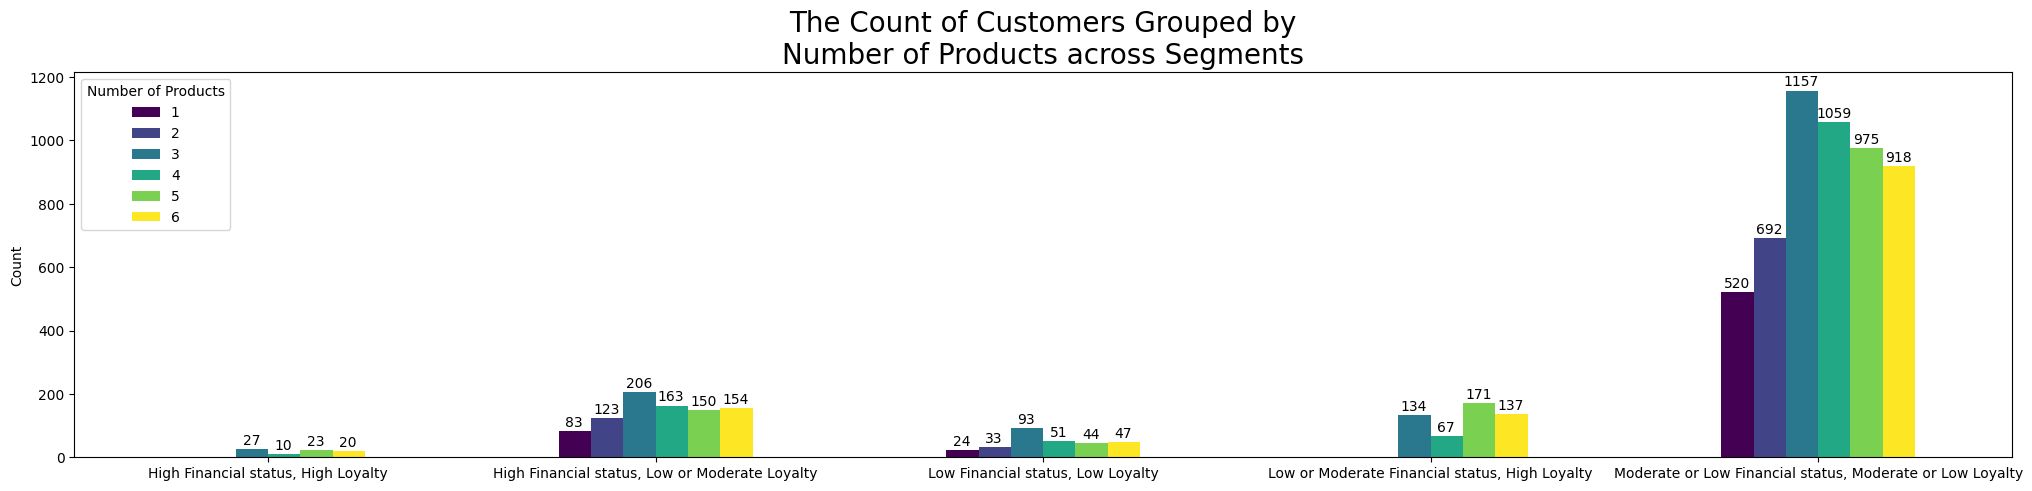

In [379]:
product_usage_df = segmentation_test.df.groupby('Segment')['No_of_product'].value_counts().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(25, 5))

product_usage_df.plot(kind='bar', ax=ax, colormap='viridis')

for i in range(product_usage_df.shape[0]):
    for j in range(product_usage_df.shape[1]):
        count = product_usage_df.iat[i, j]
        if count != 0:
            ax.text(i+(j/product_usage_df.shape[1]-0.5)*0.5+0.04, count+5, count,
                    ha='center', va='bottom', fontsize=10)

ax.set_xlabel('')
ax.set_ylabel('Count')
ax.legend(title = 'Number of Products')
plt.title('The Count of Customers Grouped by\nNumber of Products across Segments', fontsize=20)
plt.xticks(rotation=0)
plt.show()

### 4.1.2 Bar Plot for Product Usage across Non-Default Segments

The default segment, **Moderate or Low Financial status, Moderate or Low Loyalty**, contains much more customers than the other 4 categories. Hence, we make an additional plot for **the non-default segments only** for a clearer visualisation.

In [ ]:
# Obselete

# The customers do not belong to the default segment
product_usage_df0 = product_usage_df[product_usage_df.index != 'Moderate or Low Financial status, Moderate or Low Loyalty']
# The customers belong to the default segment
product_usage_df1 = product_usage_df[product_usage_df.index == 'Moderate or Low Financial status, Moderate or Low Loyalty']

fig, axes = plt.subplots(1, 2, figsize=(50, 10))
product_usage_df0.plot(kind='bar', ax=axes[0], colormap='viridis')
for i in range(product_usage_df0.shape[0]):
    for j in range(product_usage_df0.shape[1]):
        count = product_usage_df0.iat[i, j]
        if count != 0:
            axes[0].text(i+(j/product_usage_df0.shape[1]-0.5)*0.5+0.04, count, count,
                         ha='center', va='bottom', fontsize=12.5)
product_usage_df1.plot(kind='bar', ax=axes[1], colormap='viridis')
for i in range(product_usage_df1.shape[0]):
    for j in range(product_usage_df1.shape[1]):
        count = product_usage_df1.iat[i, j]
        if count != 0:
            axes[1].text(i+(j/product_usage_df1.shape[1]-0.5)*0.5+0.04, count+5, count,
                         ha='center', va='bottom', fontsize=12.5)
axes[0].set_xticklabels([segment.replace(', ', ',\n') for segment in product_usage_df0.index.tolist()], rotation=0)
axes[1].set_xticklabels(product_usage_df1.index.tolist(), rotation=0)
axes[0].set_title('The Count of Customers Grouped by\nNumber of Products across Non-Default Segments', fontsize=25)
axes[1].set_title('The Count of Customers Grouped by\nNumber of Products for the Default Segment', fontsize=25)

for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('Count', fontsize=20)
    ax.legend(title = 'Number of Products')
    ax.tick_params(axis='both', labelsize=20)

# Obselete

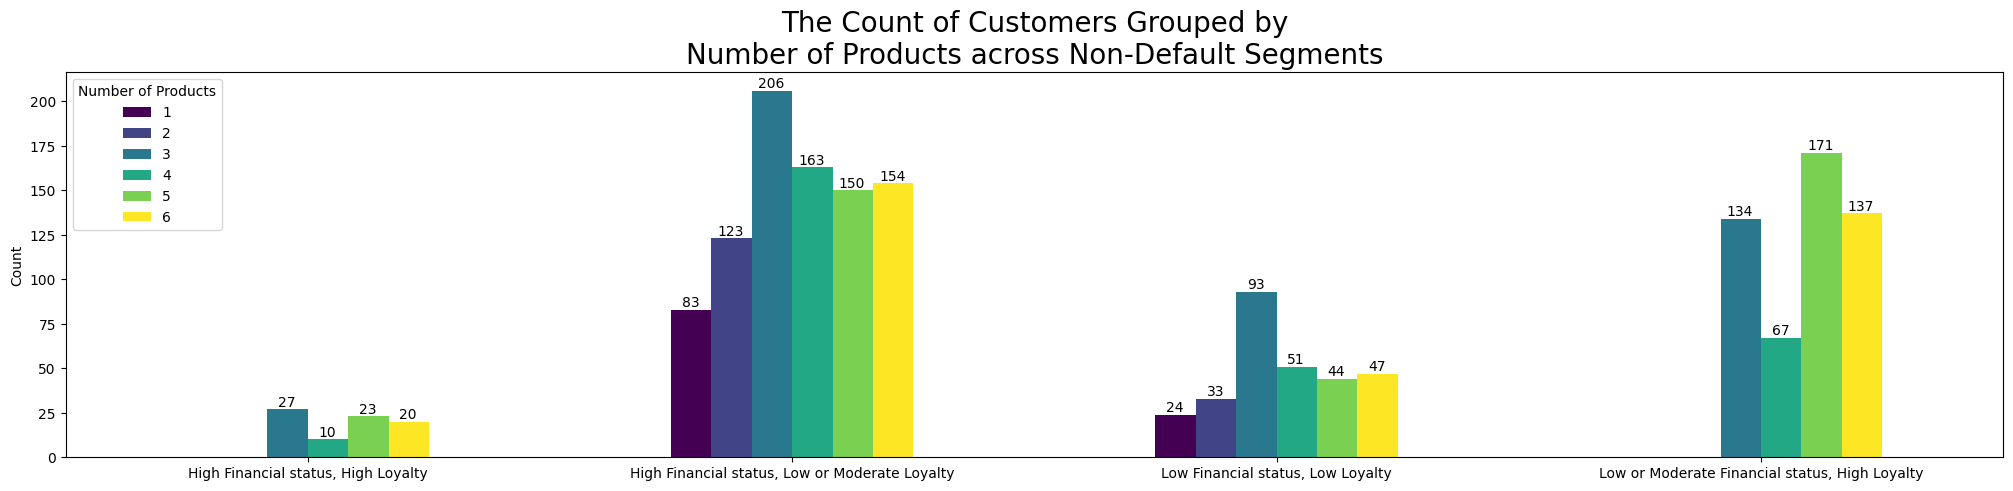

In [380]:
product_usage_df_nondefault = product_usage_df[product_usage_df.index != 'Moderate or Low Financial status, Moderate or Low Loyalty']

fig, ax = plt.subplots(figsize=(25, 5))

product_usage_df_nondefault.plot(kind='bar', ax=ax, colormap='viridis')

for i in range(product_usage_df_nondefault.shape[0]):
    for j in range(product_usage_df_nondefault.shape[1]):
        count = product_usage_df_nondefault.iat[i, j]
        if count != 0:
            ax.text(i+(j/product_usage_df_nondefault.shape[1]-0.5)*0.5+0.04, count, count,
                    ha='center', va='bottom', fontsize=10)

ax.set_xlabel('')
ax.set_ylabel('Count')
ax.legend(title = 'Number of Products')
plt.title('The Count of Customers Grouped by\nNumber of Products across Non-Default Segments', fontsize=20)
plt.xticks(rotation=0)
plt.show()

## 4.2 Visualisation for Transaction History

### 4.2.1 Visualisation for Transaction Amount across Segments

/var/folders/yn/5n1n65mx1gj_05gy9sfw9y4c0000gn/T/ipykernel_26813/2068623669.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([segment.replace(', ', ',\n') for segment in trans_amount_df.index.tolist()], rotation=0)


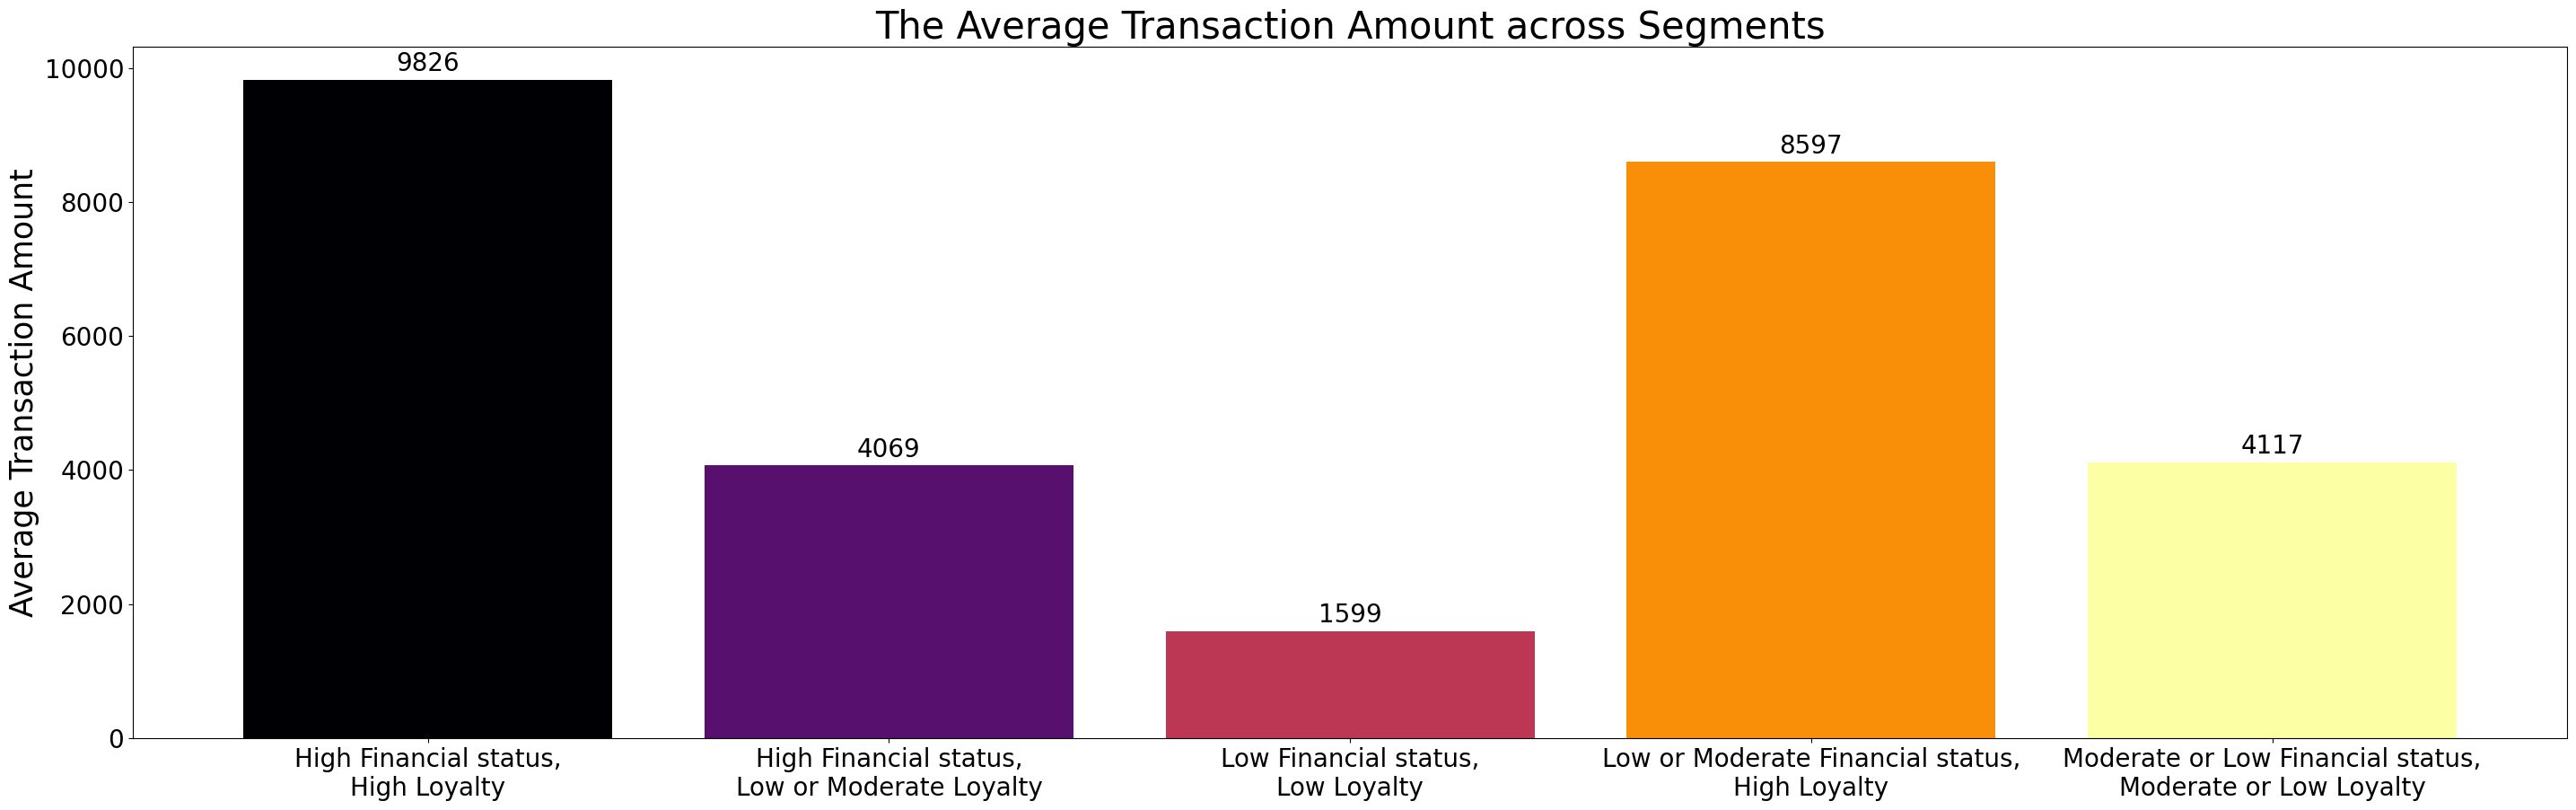

In [210]:
trans_amount_df = segmentation_test.df.groupby('Segment')['Total_Trans_Amt'].mean()

fig, ax = plt.subplots(figsize=(35, 10))
colours = plt.cm.inferno(np.linspace(0, 1, len(trans_amount_df)))
bars = ax.bar(trans_amount_df.index, trans_amount_df.values, color=colours)
#trans_amount_df.plot(kind='bar', ax=ax, color=colours)
for bar in bars:
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+50, int(bar.get_height()),
            ha='center', va='bottom', fontsize=20)
ax.set_xticklabels([segment.replace(', ', ',\n') for segment in trans_amount_df.index.tolist()], rotation=0)
ax.tick_params(axis='both', labelsize=20)
ax.set_xlabel('')
ax.set_ylabel('Average Transaction Amount', fontsize=25)
plt.title('The Average Transaction Amount across Segments', fontsize=30)
plt.show()

### 4.2.2 Visualisation for Transaction Count across Segments

/var/folders/yn/5n1n65mx1gj_05gy9sfw9y4c0000gn/T/ipykernel_26813/3435899487.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([segment.replace(', ', ',\n') for segment in trans_count_df.index.tolist()], rotation=0)


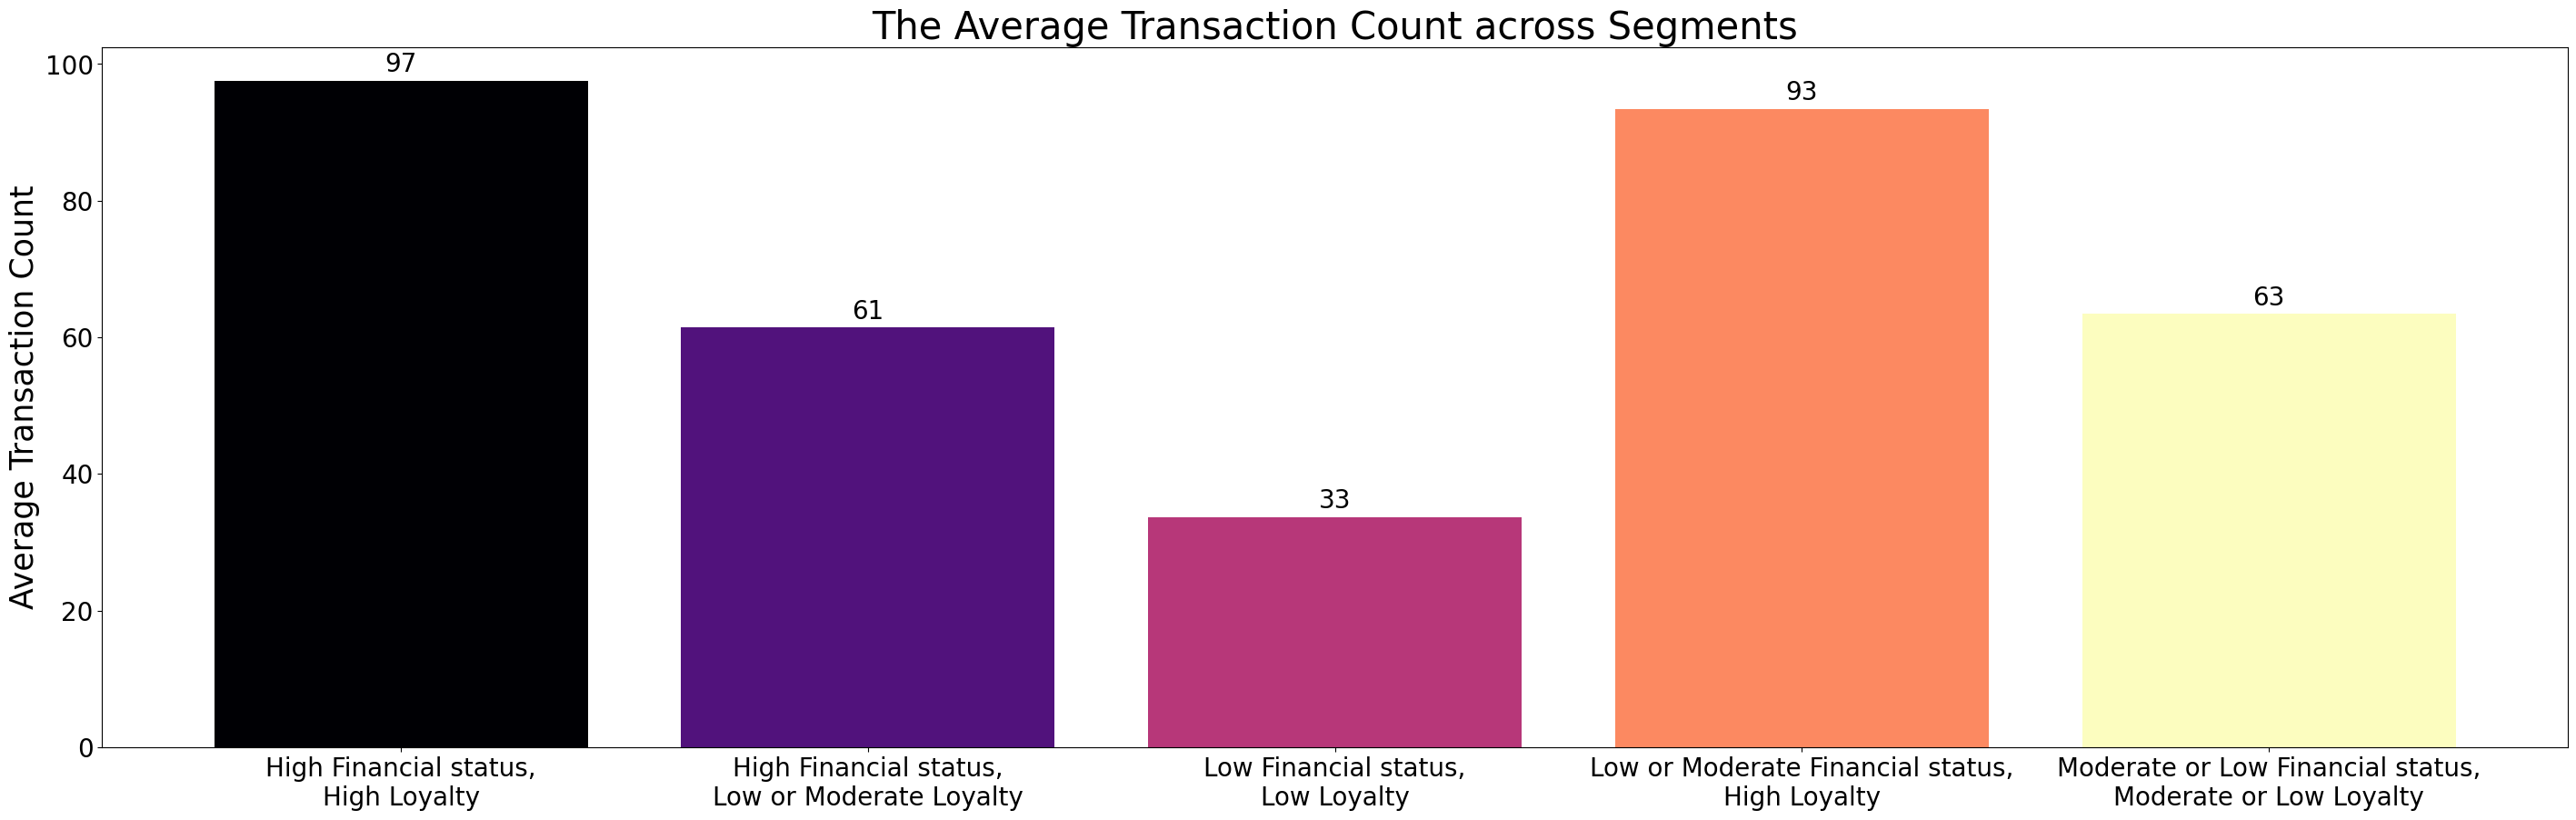

In [214]:
trans_count_df = segmentation_test.df.groupby('Segment')['Total_Trans_Count'].mean()

fig, ax = plt.subplots(figsize=(35, 10))
colours = plt.cm.magma(np.linspace(0, 1, len(trans_count_df)))
bars = ax.bar(trans_count_df.index, trans_count_df.values, color=colours)
#trans_count_df.plot(kind='bar', ax=ax, color=colours)
for bar in bars:
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5, int(bar.get_height()),
            ha='center', va='bottom', fontsize=20)
ax.set_xticklabels([segment.replace(', ', ',\n') for segment in trans_count_df.index.tolist()], rotation=0)
ax.tick_params(axis='both', labelsize=20)
ax.set_xlabel('')
ax.set_ylabel('Average Transaction Count', fontsize=25)
plt.title('The Average Transaction Count across Segments', fontsize=30)
plt.show()

## 4.3 Visualisation for Digital Engagement

### 4.3.1 Data Preprocessing

In [ ]:
digital_df = segmentation_test.df[['Digital_Capability', 'PhoneService', 'InternetService', 
                                   'TechSupport', 'PaperlessBilling', 'PaymentMethod']]

digital_df['PhoneService'] = \
    digital_df['PhoneService'].replace({0: 'No', 
                                        1: 'Yes'})
digital_df['InternetService'] = \
    digital_df['InternetService'].replace({0: 'DSL', 
                                           1: 'Fiber Optic',
                                           2: 'No Internet Service'})
digital_df['TechSupport'] = \
    digital_df['TechSupport'].replace({0: 'No', 
                                       1: 'No Internet Service',
                                       2: 'Yes'})
digital_df['PaperlessBilling'] = \
    digital_df['PaperlessBilling'].replace({0: 'No', 
                                            1: 'Yes'})
digital_df['PaymentMethod'] = \
    digital_df['PaymentMethod'].replace({0: 'Bank transfer (automatic)', 
                                         1: 'Credit card (automatic)',
                                         2: 'Electronic check',
                                         3: 'Mailed check'})

In [ ]:
# OBSELETE

phone_service_df = digital_df.groupby('Digital_Capability')['PhoneService'].value_counts().unstack(fill_value=0)
internet_service_df = digital_df.groupby('Digital_Capability')['InternetService'].value_counts().unstack(fill_value=0)
tech_support_df = digital_df.groupby('Digital_Capability')['TechSupport'].value_counts().unstack(fill_value=0)
paperless_billing_df = digital_df.groupby('Digital_Capability')['PaperlessBilling'].value_counts().unstack(fill_value=0)
payment_method_df = digital_df.groupby('Digital_Capability')['PaymentMethod'].value_counts().unstack(fill_value=0)

fig, axes = plt.subplots(1, 5, figsize=(10, 5), sharey=True)
phone_service_df.plot(kind='bar', stacked=True, ax=axes[0], colormap='plasma')
internet_service_df.plot(kind='bar', stacked=True, ax=axes[1], colormap='plasma')
tech_support_df.plot(kind='bar', stacked=True, ax=axes[2], colormap='plasma')
paperless_billing_df.plot(kind='bar', stacked=True, ax=axes[3], colormap='plasma')
payment_method_df.plot(kind='bar', stacked=True, ax=axes[4], colormap='plasma')
axes[0].set_ylabel('Count')
plt.suptitle('Technical Usage', fontsize=20)

# OBSELETE

### 4.3.2 Visualisation for Count of Customers with Different Technical Features

/var/folders/yn/5n1n65mx1gj_05gy9sfw9y4c0000gn/T/ipykernel_26813/955785671.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].text(j, curr_height[j]-count/2, count,
/var/folders/yn/5n1n65mx1gj_05gy9sfw9y4c0000gn/T/ipykernel_26813/955785671.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].text(j, curr_height[j]-count/2, count,
/var/folders/yn/5n1n65mx1gj_05gy9sfw9y4c0000gn/T/ipykernel_26813/955785671.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

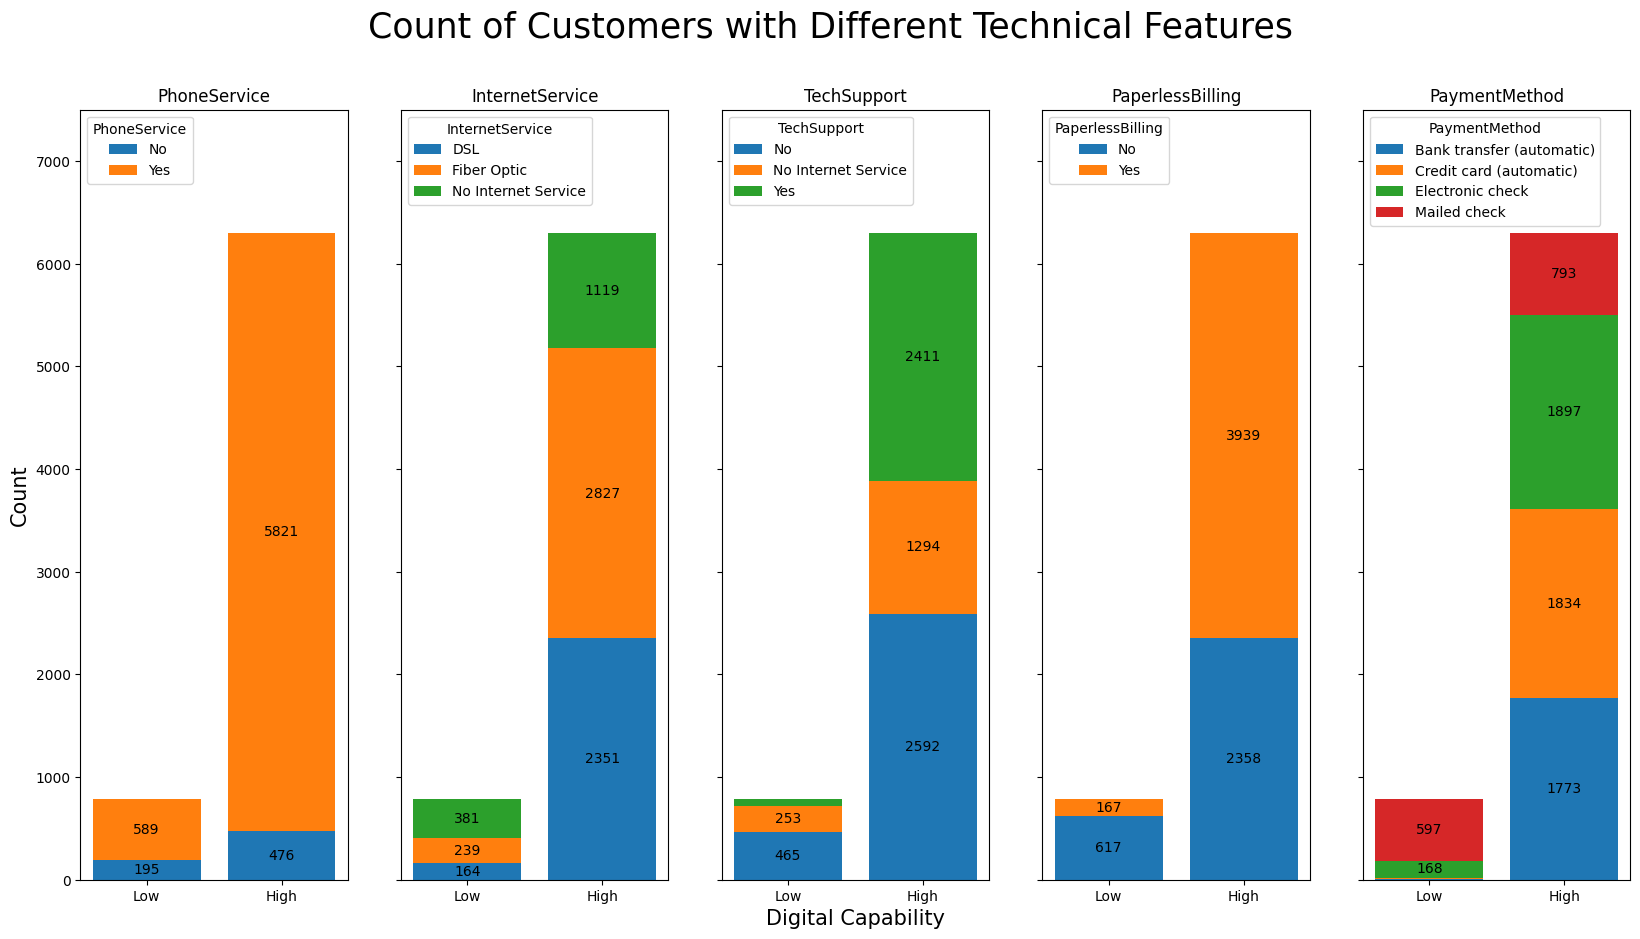

In [364]:
digital_features = ['PhoneService', 'InternetService', 'TechSupport', 'PaperlessBilling', 'PaymentMethod']

fig, axes = plt.subplots(1, 5, figsize=(20, 10), sharey=True)

for i, feature in enumerate(digital_features):
    counts = digital_df.groupby('Digital_Capability')[feature].value_counts().unstack(fill_value=0)

    curr_height = np.zeros(len(counts))

    for category in counts.columns:
        axes[i].bar(counts.index, counts[category], bottom=curr_height, label=category)
        curr_height += counts[category]

        for j, count in enumerate(counts[category]):
            if count > 100:
                axes[i].text(j, curr_height[j]-count/2, count,
                            ha='center', va='center', fontsize=10)
    
    axes[i].set_ylim(0, 7500)
    axes[i].set_title(feature)
    axes[i].set_xticks(counts.index)
    axes[i].set_xticklabels(['Low', 'High'])
    axes[i].legend(title=feature, bbox_to_anchor=(0,1), loc='upper left')

axes[0].set_ylabel('Count', fontsize=15)
axes[2].set_xlabel('Digital Capability', fontsize=15)
plt.suptitle('Count of Customers with Different Technical Features', fontsize=25)
plt.show()

### 4.3.3 Visualisation for Proportion of Customers with Different Technical Features

/var/folders/yn/5n1n65mx1gj_05gy9sfw9y4c0000gn/T/ipykernel_26813/230686919.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].text(j, curr_height[j]-proportion/2, f'{round(proportion*100, 1)}%', ha='center', va='center', fontsize=10)
/var/folders/yn/5n1n65mx1gj_05gy9sfw9y4c0000gn/T/ipykernel_26813/230686919.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].text(j, curr_height[j]-proportion/2, f'{round(proportion*100, 1)}%', ha='center', va='center', fontsize=10)
/var/folders/yn/5n1n65mx1gj_05gy9sfw9y4c0000gn/T/ipykernel_26813/230686919.py:16: FutureWarning: Series.__getitem__ treating keys as pos

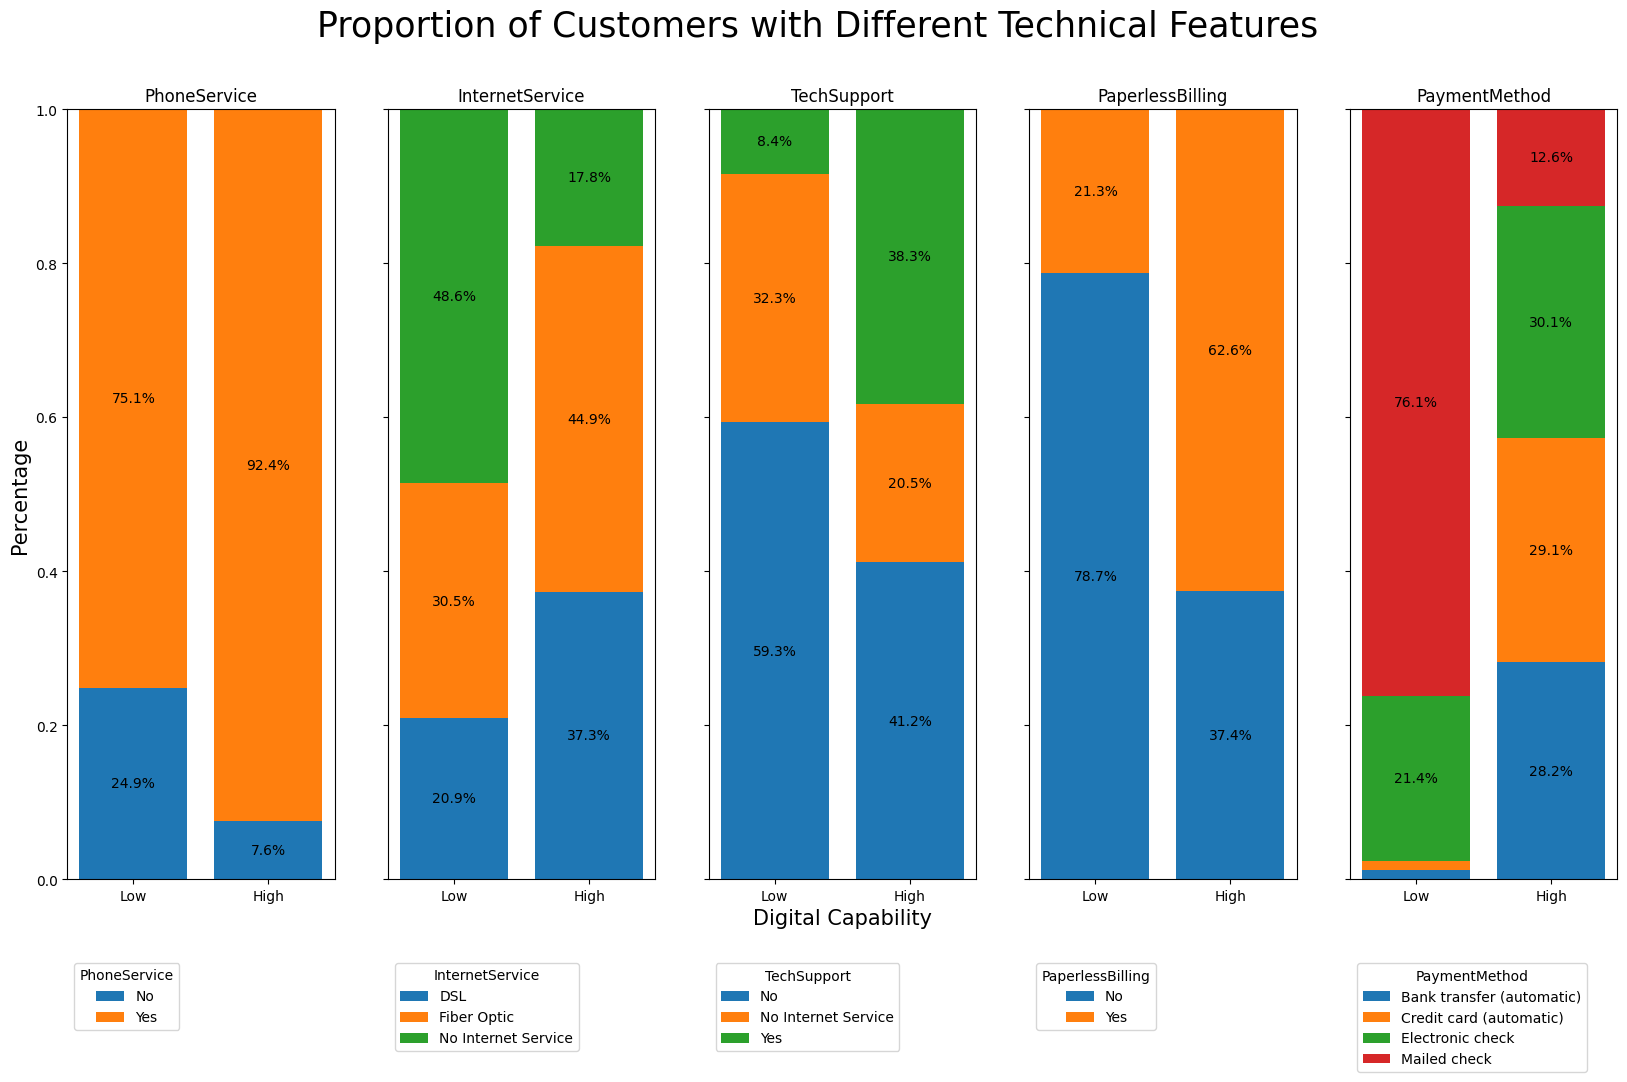

In [382]:
digital_features = ['PhoneService', 'InternetService', 'TechSupport', 'PaperlessBilling', 'PaymentMethod']

fig, axes = plt.subplots(1, 5, figsize=(20, 10), sharey=True)

for i, feature in enumerate(digital_features):
    proportions = digital_df.groupby('Digital_Capability')[feature].value_counts(normalize=True).unstack(fill_value=0)

    curr_height = np.zeros(len(proportions))

    for category in proportions.columns:
        axes[i].bar(proportions.index, proportions[category], bottom=curr_height, label=category)
        curr_height += proportions[category]

        for j, proportion in enumerate(proportions[category]):
            if proportion > 0.05:
                axes[i].text(j, curr_height[j]-proportion/2, f'{round(proportion*100, 1)}%', ha='center', va='center', fontsize=10)
    
    axes[i].set_ylim(0, 1)
    axes[i].set_title(feature)
    axes[i].set_xticks(proportions.index)
    axes[i].set_xticklabels(['Low', 'High'])
    axes[i].legend(title=feature, bbox_to_anchor=(0,-0.10), loc='upper left')

axes[0].set_ylabel('Percentage', fontsize=15)
axes[2].set_xlabel('Digital Capability', fontsize=15)
plt.suptitle('Proportion of Customers with Different Technical Features', fontsize=25)
plt.show()